# FAQ 2: What about line blending?

High resolution spectra can suffer from line blending, in which adjacent lines reside within a spectrograph's instrumental resolution element.  

In short, `blase` is currently agnostic to the provenance of spectral lines.  Lines may represent blends, and in some cases should be considered "pseudo-lines", arising from pairs or groups of lesser lines.  So the interpretation of the line properties obtained from `blase` depend somewhat on the spectral type and other problem-specific assumptions.  

`blase` applies a heuristic threshold when detecting lines: adjacent lines must be more than a few pixels away from each other.  This threshold is hypothetically tunable, and we welcome experiment in this area.  In practice we have found the default value to provide adequate line detection.

Here we explore a few other questions around line density, and provide some ways for you to explore this question on your own.

In [1]:
import torch
from blase.emulator import SparseLogEmulator
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Let's do everything identically as the Step 1 tutorial.

In [3]:
wl_lo = 8079-30
wl_hi = 12785+30

### PHOENIX spectrum

In [8]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

In [9]:
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()
continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")

In [10]:
ln_flux_native = np.log(stellar_spectrum.flux.value)

### TelFit spectrum

In [11]:
#local_file = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp290_hum040.txt'
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [12]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) & 
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

In [13]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`
telluric_lnflux[telluric_lnflux < -15] = -15

In [14]:
%%capture
telluric_emulator = SparseLogEmulator(telluric_wl, telluric_lnflux, 
                             wing_cut_pixels=1000, prominence=0.01, device=device)
telluric_emulator.to(device)

We only want to find the lines, not tune them, so let's just provide a narrow wing cut.

In [15]:
%%capture
stellar_emulator = SparseLogEmulator(stellar_spectrum.wavelength.value, 
                             ln_flux_native, 
                             wing_cut_pixels=1000, prominence=0.01, device=device)
stellar_emulator.to(device)

In [16]:
stellar_lines = stellar_emulator.lam_centers.detach().cpu().numpy()
telluric_lines = telluric_emulator.lam_centers.detach().cpu().numpy()

In [17]:
bins = np.arange(wl_lo, wl_hi, 100.0)

## What is the line density?

We want to identify places with high density of stellar and telluric lines.

In [19]:
import seaborn as sns

In [25]:
sns.set_context('paper', font_scale=1.3)

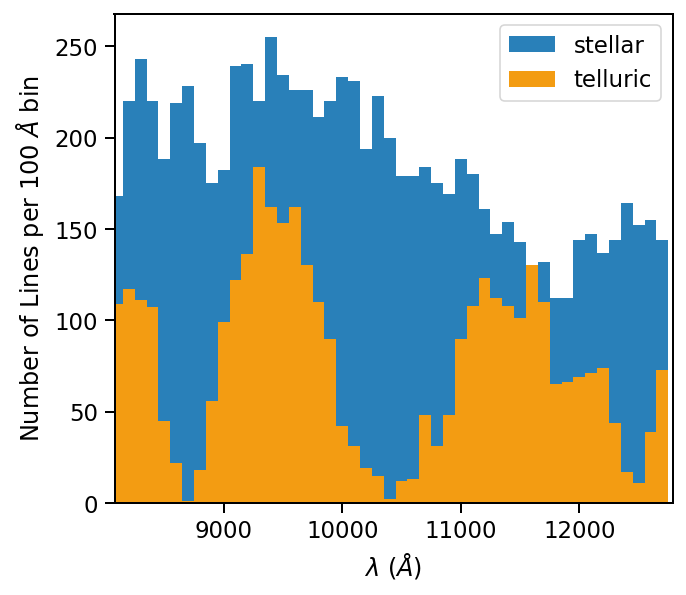

In [35]:
plt.figure(figsize=(5,4.5))
plt.hist(stellar_lines, bins=bins, label='stellar', color='#2980b9');
plt.hist(telluric_lines, bins=bins, label='telluric', color='#f39c12');
plt.xlabel('$\lambda ~(\AA)$', fontsize=12)
#plt.axvline(8300, linestyle='dashed', color='k')
#plt.axvline(8400, linestyle='dashed', color='k')
#plt.axvline(12500, linestyle='dotted', color='k')
#plt.axvline(12650, linestyle='dotted', color='k')

plt.legend()
plt.ylabel('Number of Lines per 100 $\AA$ bin', fontsize=12)
plt.xlim(wl_lo+30, wl_hi-30);
plt.savefig('../../paper/paper1/figures/line_density_demo.png', bbox_inches='tight', dpi=300)

It looks like we achieve as many as 250 spectral lines in a 100 Angstrom bin.  Some of those may be blends, and again the question is problem-specific and depends on the native resolution of your input spectrum.

I have highlighted two exemplar regions with vertical bars in the plot above.  These two regions may serve as good laboratories for answering the question: "Where are the locations where stellar lines and telluric lines co-exist, but where the telluric lines don't blot out everything?"  Such regions are useful for test-driving `blase`.

### What are good exemplar regions for test-driving `blase`?

These two regions have a high degree of inter-mingling among deep stellar and telluric lines.

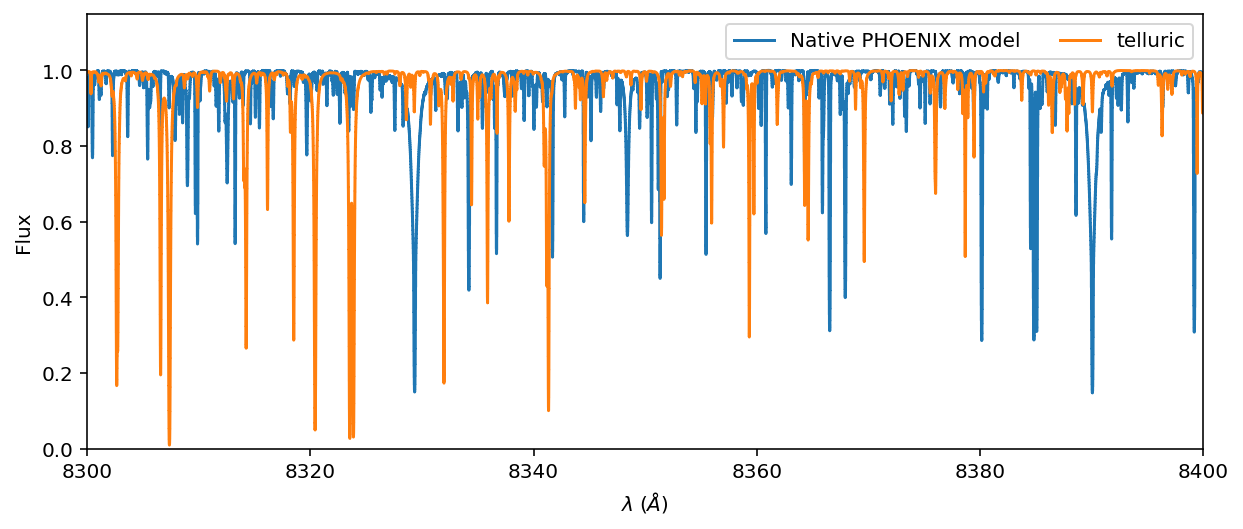

In [15]:
ax = stellar_spectrum.plot(ylo=0.0, yhi=1.15, label='Native PHOENIX model')
telluric_spectrum.plot(ax=ax, label='telluric')
ax.set_xlim(8300, 8400)
ax.legend(loc='upper right', ncol=2);

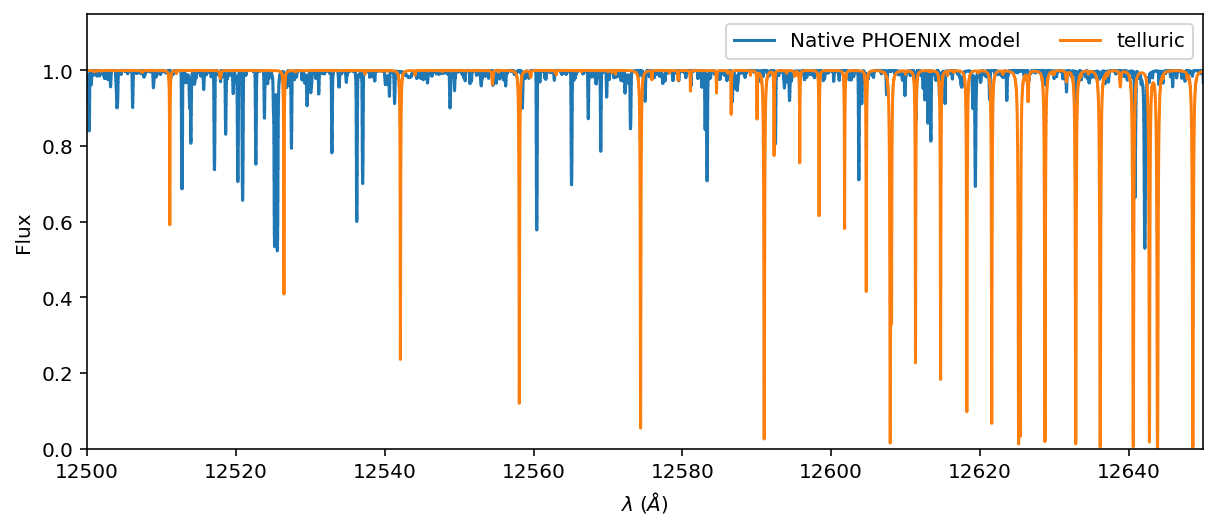

In [16]:
ax = stellar_spectrum.plot(ylo=0.0, yhi=1.15, label='Native PHOENIX model')
telluric_spectrum.plot(ax=ax, label='telluric')
ax.set_xlim(12500, 12650)
ax.legend(loc='upper right', ncol=2);

Awesome! Thank you for asking these questions, if you have more questions about `blase` or related topics, please open a [GitHub Issue](https://github.com/gully/blase/issues).